# Preamble

In [3]:
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt

In [4]:
# Set this to false for faster execution time
SHOW_IMAGES = True

# Whether or not to save matplotlib figures as pdf output file for latex
USE_LATEX_ENGINE = True

if USE_LATEX_ENGINE:
    import matplotlib
    # matplotlib.use("pgf")     # pgf doesn't work for some plots because they exceed the max value that pgf can calculate
    matplotlib.rcParams.update({
        # "pgf.texsystem": "pdflatex",
        # 'pgf.rcfonts': False,
        'font.family': 'serif',
        'text.usetex': True,
    })

# Function Definitions

In [5]:
def _generate_output_string(element, data):
    """
    Returns a string that contains information about the percentual share of a value in a list
    """
    # if not isinstance(element, str): # make sure element is of type string, convert otherwise
    #     element = str(element)
    
    n_total = len(data)
    bool_list = (data == element)
    n_elements = sum(bool_list)

    return "{:<30}".format(str(n_elements) + '/' + str(n_total) + ' (' + "{:.2f}".format(((n_elements / n_total) * 100)) + '%)')

In [6]:
def calculate_percentages(normal_data, pneumonia_data, additional_df=None):
    """
    checks if two lists contain the same set of values - returns a warning if the sets dont match - prints a string with information about the distribution if they match
    """
    if len(set(normal_data)) is not len(set(pneumonia_data)):
        print('WARNING! Categories of healthy and pneumonia data are not identical!')
        print('Normal: ' + str(set(normal_data)))
        print('Pneumonia: ' + str(set(pneumonia_data)))
        print('Number of appearences (normal):')
        n_normal_set = ''
        for category in set(normal_data):
            n_normal_set += "'" + str(category) + "': " + str(sum(normal_data == category)) + '\n'   # single quote: non-escaped string, double quote: escaped string
        print(n_normal_set)
        return
    else:
        print(set(normal_data))
    if additional_df is None:
        print('{:<21}'.format('') + '{:<30}'.format('normal') + '{:<30}'.format('pneumonia'))
    else:
        print('{:<21}'.format('') + '{:<30}'.format('normal (total)') + '{:<30}'.format('normal (filtered)') + '{:<30}'.format('pneumonia'))

    for element in set(normal_data):
        category_string = "{:<21}".format(str(element) + ': ')
        if additional_df is None:
            print(category_string + _generate_output_string(element, normal_data) + _generate_output_string(element, pneumonia_data))
        else:
            print(category_string + _generate_output_string(element, normal_data) + _generate_output_string(element, additional_df) + _generate_output_string(element, pneumonia_data))

In [7]:
def find_appearences(df, column, value):
    """
    searches for appearences of a specified value within the column of a dataframe - prints the number of appearences and the corresponding indexes
    """
    
    value = str(value)
    print('found ' + str(sum(df[column] == value)) + ' rows')
    index_list = df.index[df[column] == value].tolist()
    print('Indexes: ' + str(index_list))
    return index_list

In [8]:
def drop_from_column(df, column, value, convert_to_string=True):
    """
    searches for appearences of a specified value within a column of a dataframe - drops each row where the value appeared from the dataframe
    """
    if convert_to_string:
        value = str(value)
    print('Dropping ' + str(sum(df[column] == value)) + ' rows')
    index_list = df.index[df[column] == value].tolist()
    df.drop(index_list, inplace=True)

# Data preparation

In [9]:
path_cxr14 = '/mnt/f/05_DatensaetzeJan/ChestX-ray14_NIH/'
file_name_meta_data = 'Data_Entry_2017_v2020.csv'

meta_data_df = pd.read_csv(path_cxr14 + file_name_meta_data)
meta_data_df.reset_index(drop=True, inplace=True)

print('length of meta data:', len(meta_data_df))

length of meta data: 112120


In [10]:
print('Description of', len(set(meta_data_df)), 'columns (meta data):')
set(meta_data_df)

Description of 11 columns (meta data):


{'Finding Labels',
 'Follow-up #',
 'Height]',
 'Image Index',
 'OriginalImagePixelSpacing[x',
 'OriginalImage[Width',
 'Patient Age',
 'Patient Gender',
 'Patient ID',
 'View Position',
 'y]'}

In [11]:
# replacing nan with 'nan'
meta_data_df.fillna('nan', inplace=True)
meta_data_df.rename(columns={"Finding Labels": "FindingLabels", "Follow-up #": "FollowUp", "Image Index": "ImageIndex", "Patient Age": "PatientAge", "Patient Gender": "PatientGender", "Patient ID": "PatientID", "View Position": "ViewPosition"}, errors='raise', inplace=True)

In [12]:
len(meta_data_df)

112120

In [13]:
set(meta_data_df)

{'FindingLabels',
 'FollowUp',
 'Height]',
 'ImageIndex',
 'OriginalImagePixelSpacing[x',
 'OriginalImage[Width',
 'PatientAge',
 'PatientGender',
 'PatientID',
 'ViewPosition',
 'y]'}

In [14]:
print('Gender')
calculate_percentages(meta_data_df['PatientGender'], meta_data_df['PatientGender'])
print('\nProjection')
calculate_percentages(meta_data_df['ViewPosition'], meta_data_df['ViewPosition'])

Gender
{'F', 'M'}
                     normal                        pneumonia                     
F:                   48780/112120 (43.51%)         48780/112120 (43.51%)         
M:                   63340/112120 (56.49%)         63340/112120 (56.49%)         

Projection
{'AP', 'PA'}
                     normal                        pneumonia                     
AP:                  44810/112120 (39.97%)         44810/112120 (39.97%)         
PA:                  67310/112120 (60.03%)         67310/112120 (60.03%)         


In [15]:
len(set(meta_data_df['FindingLabels']))

836

In [16]:
meta_data_df.sample(n=5).ImageIndex

60532    00014945_006.png
7173     00001900_014.png
61515    00015184_002.png
79551    00019542_000.png
22333    00005920_004.png
Name: ImageIndex, dtype: object

In [17]:
print('Pneumonia samples', len(meta_data_df[meta_data_df['FindingLabels'].str.contains('pneumonia', case=False) & ~meta_data_df['FindingLabels'].str.contains('no finding', case=False)])) # second boolean part doesnt change the number
print('No finding samples', len(meta_data_df[meta_data_df['FindingLabels'].str.contains('no finding', case=False) & ~meta_data_df['FindingLabels'].str.contains('pneumonia', case=False)]))# second boolean part doesnt change the number
print('Samples not containing pneumonia label', len(meta_data_df[~meta_data_df['FindingLabels'].str.contains('pneumonia', case=False)]))

Pneumonia samples 1431
No finding samples 60361
Samples not containing pneumonia label 110689


In [18]:
pneumonia_df = meta_data_df[meta_data_df['FindingLabels'].str.contains('pneumonia', case=False)]
normal_df = meta_data_df[meta_data_df['FindingLabels'].str.contains('no finding', case=False)]

In [19]:
print('Gender')
calculate_percentages(normal_df['PatientGender'], pneumonia_df['PatientGender'])
print('\nProjection')
calculate_percentages(normal_df['ViewPosition'], pneumonia_df['ViewPosition'])

Gender
{'F', 'M'}
                     normal                        pneumonia                     
F:                   26439/60361 (43.80%)          593/1431 (41.44%)             
M:                   33922/60361 (56.20%)          838/1431 (58.56%)             

Projection
{'AP', 'PA'}
                     normal                        pneumonia                     
AP:                  21059/60361 (34.89%)          801/1431 (55.97%)             
PA:                  39302/60361 (65.11%)          630/1431 (44.03%)             


=== 1. sample study ===
Findings: Effusion
ViewPosition: PA , Gender M Age 59
/mnt/f/05_DatensaetzeJan/ChestX-ray14_NIH/images/00009378_005.png


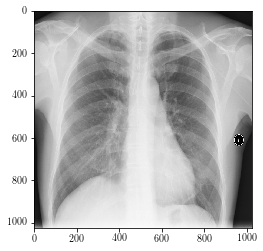



=== 2. sample study ===
Findings: No Finding
ViewPosition: AP , Gender M Age 23
/mnt/f/05_DatensaetzeJan/ChestX-ray14_NIH/images/00026099_032.png


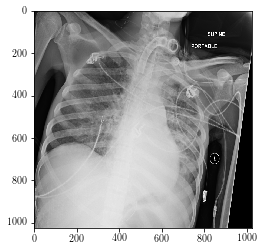



=== 3. sample study ===
Findings: Effusion|Infiltration
ViewPosition: AP , Gender M Age 69
/mnt/f/05_DatensaetzeJan/ChestX-ray14_NIH/images/00008030_004.png


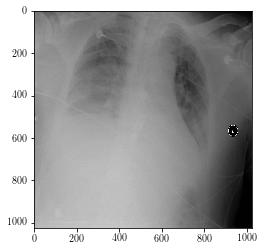



=== 4. sample study ===
Findings: No Finding
ViewPosition: PA , Gender M Age 27
/mnt/f/05_DatensaetzeJan/ChestX-ray14_NIH/images/00013175_006.png


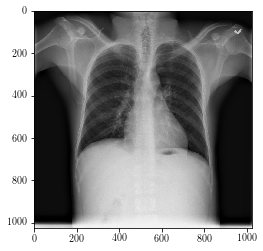



=== 5. sample study ===
Findings: No Finding
ViewPosition: AP , Gender F Age 36
/mnt/f/05_DatensaetzeJan/ChestX-ray14_NIH/images/00020312_014.png


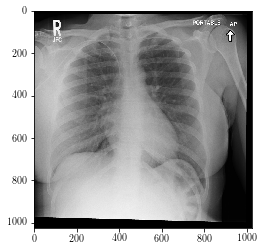



=== 6. sample study ===
Findings: No Finding
ViewPosition: AP , Gender M Age 54
/mnt/f/05_DatensaetzeJan/ChestX-ray14_NIH/images/00019271_035.png


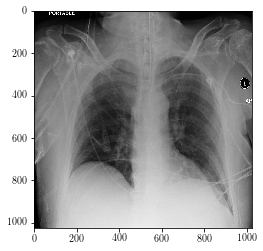



=== 7. sample study ===
Findings: Atelectasis|Cardiomegaly|Fibrosis|Mass|Pneumothorax
ViewPosition: AP , Gender F Age 67
/mnt/f/05_DatensaetzeJan/ChestX-ray14_NIH/images/00019367_000.png


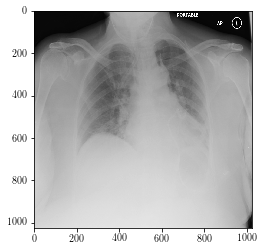



=== 8. sample study ===
Findings: No Finding
ViewPosition: AP , Gender F Age 30
/mnt/f/05_DatensaetzeJan/ChestX-ray14_NIH/images/00001437_008.png


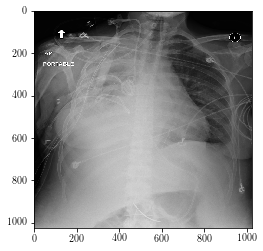



=== 9. sample study ===
Findings: Effusion
ViewPosition: PA , Gender M Age 47
/mnt/f/05_DatensaetzeJan/ChestX-ray14_NIH/images/00013247_004.png


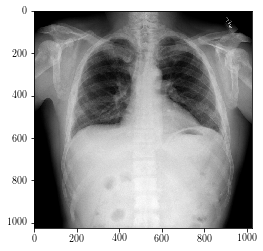



=== 10. sample study ===
Findings: Effusion|Infiltration
ViewPosition: AP , Gender F Age 62
/mnt/f/05_DatensaetzeJan/ChestX-ray14_NIH/images/00002395_011.png


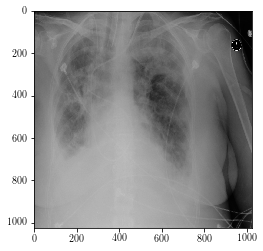

In [50]:
import matplotlib.image as mpimg

num = 1
for sample in meta_data_df.sample(n=10).itertuples():
    if not SHOW_IMAGES:
        break

    print('=== ' + str(num) + '. sample study ===')
    print('Findings:', sample.FindingLabels)
    print('ViewPosition:', sample.ViewPosition, '| Gender:', sample.PatientGender, '| Age:', sample.PatientAge)
    
    num = num + 1
    
    file_path = path_cxr14 + 'images/' + str(sample.ImageIndex)
    print(file_path)
    plt.figure(num)
    img = mpimg.imread(file_path)
    imgplot = plt.imshow(img, cmap="gray")
    plt.show()
    
    print('\n')



In [20]:
pneumonia_patientids = set(pneumonia_df['PatientID'])
normal_patientids = set(normal_df['PatientID'])

duplicate_ids = pneumonia_patientids.intersection(normal_patientids)
print(len(duplicate_ids), 'of', len(pneumonia_patientids), 'pneumonia patients are also present in normal patients (total of', len(normal_patientids), 'unique normal patients)')

res = normal_df[normal_df['PatientID'].apply(lambda x: x in duplicate_ids)]
print('This affects', len(res), 'of', len(normal_df), 'normal samples')

863 of 1008 pneumonia patients are also present in normal patients (total of 24907 unique normal patients)
This affects 7259 of 60361 normal samples


In [21]:
# Dropping duplicates in normal data
normal_df.drop(res.index, inplace=True)

In [22]:
len(normal_df)

53102

# Data Analysis

In [23]:
print('Gender')
calculate_percentages(normal_df['PatientGender'], pneumonia_df['PatientGender'])
print('\nProjection')
calculate_percentages(normal_df['ViewPosition'], pneumonia_df['ViewPosition'])

Gender
{'F', 'M'}
                     normal                        pneumonia                     
F:                   23563/53102 (44.37%)          593/1431 (41.44%)             
M:                   29539/53102 (55.63%)          838/1431 (58.56%)             

Projection
{'AP', 'PA'}
                     normal                        pneumonia                     
AP:                  16467/53102 (31.01%)          801/1431 (55.97%)             
PA:                  36635/53102 (68.99%)          630/1431 (44.03%)             


# Stratified Sampling from Kaggle

In [24]:
'''
This module contains functions that computes stratified sampling of pandas dataframes.
'''
# Required libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Functions

In [25]:
def __smpl_size(population, size):
    '''
    A function to compute the sample size. If not informed, a sampling 
    size will be calculated using Cochran adjusted sampling formula:
        cochran_n = (Z**2 * p * q) /e**2

        where:
            - Z is the z-value. In this case we use 1.96 representing 95%
            - p is the estimated proportion of the population which has an
                attribute. In this case we use 0.5
            - q is 1-p
            - e is the margin of error

        This formula is adjusted as follows:
        adjusted_cochran = cochran_n / 1+((cochran_n -1)/N)

        where:
            - cochran_n = result of the previous formula
            - N is the population size
    Parameters
    ----------
        :population: population size
        :size: sample size (default = None)
    Returns
    -------
    Calculated sample size to be used in the functions:
        - stratified_sample
        - stratified_sample_report
    '''
    if size is None:
        cochran_n = round(((1.96)**2 * 0.5 * 0.5)/ 0.02**2)
        n = round(cochran_n/(1+((cochran_n -1) /population)))
    elif size >= 0 and size < 1:
        n = round(population * size)
    elif size < 0:
        raise ValueError('Parameter "size" must be an integer or a proportion between 0 and 0.99.')
    elif size >= 1:
        n = size
    return n

In [26]:
def stratified_sample_report(df, strata, size=None):
    '''
    Generates a dataframe reporting the counts in each stratum and the counts
    for the final sampled dataframe.

    Parameters
    ----------
    :df: pandas dataframe from which data will be sampled.
    :strata: list containing columns that will be used in the stratified sampling.
    :size: sampling size. If not informed, a sampling size will be calculated
        using Cochran adjusted sampling formula:
        cochran_n = (Z**2 * p * q) /e**2

        where:
            - Z is the z-value. In this case we use 1.96 representing 95%
            - p is the estimated proportion of the population which has an
                attribute. In this case we use 0.5
            - q is 1-p
            - e is the margin of error

        This formula is adjusted as follows:
        adjusted_cochran = cochran_n / 1+((cochran_n -1)/N)

        where:
            - cochran_n = result of the previous formula
            - N is the population size

    Returns
    -------
    A dataframe reporting the counts in each stratum and the counts
    for the final sampled dataframe.
    '''
    population = len(df)
    size = __smpl_size(population, size)
    tmp = df[strata]
    tmp['size'] = 1
    tmp_grpd = tmp.groupby(strata).count().reset_index()
    tmp_grpd['samp_size'] = round(size/population * tmp_grpd['size']).astype(int)
    return tmp_grpd

In [27]:
def stratified_sample_transferred(df_target, df_proportion, strata, size=None, seed=None, keep_index= True):
    '''
    It samples data from a pandas dataframe using strata. These functions use
    proportionate stratification:
    n1 = (N1/N) * n
    where:
        - n1 is the sample size of stratum 1
        - N1 is the population size of stratum 1
        - N is the total population size
        - n is the sampling size
    Parameters
    ----------
    :df_target: pandas dataframe from which data will be sampled.
    :df_proportion: pandas dataframe from which the proportions for sampling will be used.
    :strata: list containing columns that will be used in the stratified sampling.
    :size: sampling size. If not informed, a sampling size will be calculated
        using Cochran adjusted sampling formula:
        cochran_n = (Z**2 * p * q) /e**2
        where:
            - Z is the z-value. In this case we use 1.96 representing 95%
            - p is the estimated proportion of the population which has an
                attribute. In this case we use 0.5
            - q is 1-p
            - e is the margin of error
        This formula is adjusted as follows:
        adjusted_cochran = cochran_n / 1+((cochran_n -1)/N)
        where:
            - cochran_n = result of the previous formula
            - N is the population size
    :seed: sampling seed
    :keep_index: if True, it keeps a column with the original population index indicator
    
    Returns
    -------
    A sampled pandas dataframe based in a set of strata.
    Examples
    --------
    >> df.head()
    	id  sex age city 
    0	123 M   20  XYZ
    1	456 M   25  XYZ
    2	789 M   21  YZX
    3	987 F   40  ZXY
    4	654 M   45  ZXY
    ...
    # This returns a sample stratified by sex and city containing 30% of the size of
    # the original data
    >> stratified = stratified_sample(df=df, strata=['sex', 'city'], size=0.3)
    Requirements
    ------------
    - pandas
    - numpy
    '''
    
    # population = len(df)
    # size = __smpl_size(population, size)
    # tmp = df[strata]
    # tmp['size'] = 1
    # tmp_grpd = tmp.groupby(strata).count().reset_index()
    # tmp_grpd['samp_size'] = round(size/population * tmp_grpd['size']).astype(int)


    population = len(df_proportion)
    size = __smpl_size(population, size)

    tmp_proportion = df_proportion[strata]
    tmp = df_target[strata]

    tmp_proportion['size'] = 1
    tmp['size'] = 1

    tmp_proportion_grpd = tmp_proportion.groupby(strata).count().reset_index()
    tmp_grpd = tmp.groupby(strata).count().reset_index()

    if not tmp_grpd[strata].equals(tmp_proportion_grpd[strata]):
        print(tmp_grpd)
        print(tmp_proportion_grpd)
        raise ValueError("Dataframes don't have the same groups for the given set of stratas. You can check the differences in the terminal output.")        

    tmp_proportion_grpd['samp_size'] = round(size/population * tmp_proportion_grpd['size']).astype(int)
    tmp_grpd['samp_size'] = round(size/population * tmp_proportion_grpd['size']).astype(int)

    # controlling variable to create the dataframe or append to it
    first = True
    # Hier muss nichts geändert werden, da die Gruppen ohnehin die gleichen sein sollten -> len(tmp_grpd) == len(tmp_proportion_grpd)
    for i in range(len(tmp_grpd)):
        # query generator for each iteration
        qry=''
        for s in range(len(strata)):
            stratum = strata[s]
            # Hier wird n berechnet, tmp_proportion_grpd statt tmp_grpd
            
            value = tmp_grpd.iloc[i][stratum]
            n = tmp_grpd.iloc[i]['samp_size']

            if type(value) == str:
                value = "'" + str(value) + "'"
            
            if s != len(strata)-1:
                qry = qry + stratum + ' == ' + str(value) +' & '
            else:
                qry = qry + stratum + ' == ' + str(value)
        
        # query dataframe
        queried_df = df_target.query(qry)

        # check if result contains enough samples / rows
        if len(queried_df) < n:
            print("Warning! The required number of samples (" + str(n) + ") could not be retrieved.")
            print("Using all available entries (" + str(len(queried_df)) + ") of group:")
            print(qry)
            n = len(queried_df)

        # sample dataframe
        sampled_df = queried_df.sample(n=n, random_state=seed).reset_index(drop=(not keep_index))

        # assign to final dataframe
        if first:
            stratified_df = sampled_df
            first = False
        else:
            stratified_df = stratified_df.append(sampled_df, ignore_index=True)
    
    return stratified_df

In [28]:
filtered_df = stratified_sample_transferred(normal_df, pneumonia_df, ['ViewPosition', 'PatientGender'], size=len(pneumonia_df))

print('\nFiltered dataframe has', len(filtered_df), 'samples')


Filtered dataframe has 1431 samples


print('==== Distribution of projections ====\n')
calculate_percentages(filtered_df['ViewPosition'], pneumonia_df['ViewPosition'])
print('\n==== Distribution of ViewCodeSequence_CodeMeaning ====\n')
calculate_percentages(filtered_df['ViewCodeSequence_CodeMeaning'], pneumonia_df['ViewCodeSequence_CodeMeaning'])
print('\n==== Distribution of SupportDevices ====\n')
calculate_percentages(filtered_df['SupportDevices'], pneumonia_df['SupportDevices'])

In [29]:
# Store results as csv files

In [30]:
filtered_df.to_csv('./normal_meta_data_filtered.csv')
pneumonia_df.to_csv('./pneumonia_meta_data_filtered.csv')